In [9]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from linear_modeling import *

### Load data and sample metadata

In [2]:
data_path = os.path.join(
    os.getcwd(),
    "..",
    "data",
    "S_cereviseae_compendia_recount_bio_2022_03_16"
)

In [3]:
with open(
        os.path.join(data_path, 'aggregated_metadata.json'), 'r') as jsonfile:
    metadata_file = json.load(jsonfile)

tables = {}
for k, v in metadata_file['experiments'].items():
    tables[v["accession_code"]] = v
    
metadata = pd.DataFrame(tables).T

In [4]:
data = pd.read_csv(os.path.join(data_path, "SACCHAROMYCES_CEREVISIAE.tsv"), sep="\t", header=0, index_col=0)
print("Loaded data with dimensions:", str(data.shape))

Loaded data with dimensions: (5370, 12428)


In [277]:
train = data.sample(frac=0.6, random_state=42, axis=1)
print("Train data dimensions:", train.shape)

Train data dimensions: (5370, 7457)


In [278]:
test = data.drop(train.columns, axis=1)
print("Test data dimensions:", test.shape)

Test data dimensions: (5370, 4971)


### Load gene metadata

In [279]:
# Get metadata for genes and extract genes with "transporter" annotation
gene_mapper = pd.read_csv(os.path.join(
    os.getcwd(),
    "..",
    "data",
    "yeast_orf_dict.csv"
), header=None, names=["id", "symbol", "name", "description"])

transporters = gene_mapper.loc[gene_mapper["description"].str.contains("transporter")]
transporters_list = transporters["id"].tolist()

In [280]:
# Extract transporters from data
train_transporters = train.reindex(labels=transporters_list, axis=0)
test_transporters = test.reindex(labels=transporters_list, axis=0)

In [281]:
# Get ID for transporter
_name = "CTP1"
_this = transporters.loc[transporters["symbol"] == _name]["id"].tolist()[0]

# Extract transporter from `train` and `test` for labels
training_labels = train.loc[[_this]]
test_labels = test.loc[[_this]]

# Extract all other genes `train` and `test` for input data
training_data = train.loc[train.index != _this]
test_data = test.loc[test.index != _this]

# Format axis for analysis
training_labels = np.array(training_labels.T)
test_labels = np.array(test_labels.T)
training_data = np.array(training_data.T)
test_data = np.array(test_data.T)

# Pad `train` and `test` with 1s
training_data = np.hstack((training_data, np.ones((training_data.shape[0], 1))))
test_data = np.hstack((test_data, np.ones((test_data.shape[0], 1))))

In [324]:
X = training_data
y = training_labels

In [325]:
X.shape

(7457, 5370)

In [315]:
from scipy.stats import multivariate_normal
import numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
        
# Let's make sure that we can initialize our model
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])
noise_var = 0.2
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

In [316]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: np.ndarray) -> np.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples)

In [317]:
# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)

# Generate true values and noise corrupted targets
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

# Generate dataset
features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

In [328]:
features = X[:,0]
noise_corrupted_labels = y

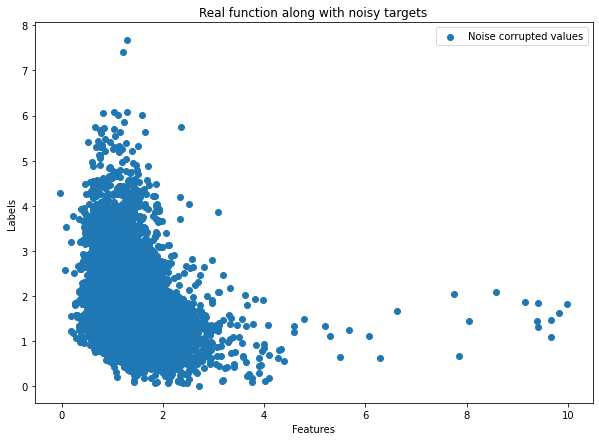

In [329]:
# Plot the dataset
plt.figure(figsize=(10,7))
plt.scatter(features, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

In [334]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(features, noise_corrupted_labels)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (5592,)
Shape y_train: (5592, 1)
Shape X_test: (1865,)
Shape y_test: (1865, 1)


In [339]:
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

In [340]:
class LinearRegression:
    
    def __init__(self):
        pass

    def train_gradient_descent(self, X, y, learning_rate=0.01, n_iters=100):
        """
        Trains a linear regression model using gradient descent
        """
        # Step 0: Initialize the parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(shape=(n_features,1))
        self.bias = 0
        costs = []

        for i in range(n_iters):
            # Step 1: Compute a linear combination of the input features and weights
            y_predict = np.dot(X, self.weights) + self.bias

            # Step 2: Compute cost over training set
            cost = (1 / n_samples) * np.sum((y_predict - y)**2)
            costs.append(cost)

            if i % 100 == 0:
                print(f"Cost at iteration {i}: {cost}")

            # Step 3: Compute the gradients
            dJ_dw = (2 / n_samples) * np.dot(X.T, (y_predict - y))
            dJ_db = (2 / n_samples) * np.sum((y_predict - y)) 
            
            # Step 4: Update the parameters
            self.weights = self.weights - learning_rate * dJ_dw
            self.bias = self.bias - learning_rate * dJ_db

        return self.weights, self.bias, costs

    def train_normal_equation(self, X, y):
        """
        Trains a linear regression model using the normal equation
        """
        self.weights = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.bias = 0
        
        return self.weights, self.bias

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

Cost at iteration 0: 3.543677435164375
Cost at iteration 100: 1.1413874693825705
Cost at iteration 200: 1.019165133768676
Cost at iteration 300: 0.9433907782526892
Cost at iteration 400: 0.8964118033440864
Cost at iteration 500: 0.8672855366997713


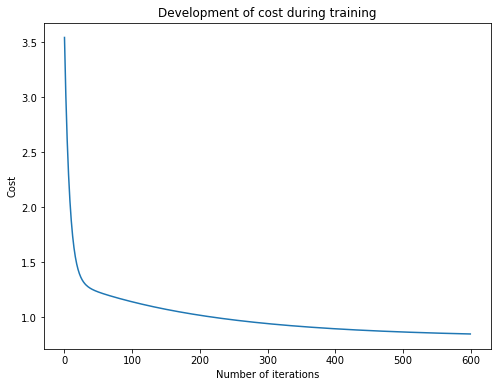

In [354]:
regressor = LinearRegression()
w_trained, b_trained, costs = regressor.train_gradient_descent(X_train, y_train, learning_rate=0.01, n_iters=600)

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(600), costs)
plt.title("Development of cost during training")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [342]:
n_samples, _ = X_train.shape
n_samples_test, _ = X_test.shape

y_p_train = regressor.predict(X_train)
y_p_test = regressor.predict(X_test)

error_train =  (1 / n_samples) * np.sum((y_p_train - y_train) ** 2)
error_test =  (1 / n_samples_test) * np.sum((y_p_test - y_test) ** 2)

print(f"Error on training set: {np.round(error_train, 4)}")
print(f"Error on test set: {np.round(error_test)}")

Error on training set: 0.9435
Error on test set: 1.0


In [343]:
# To compute the parameters using the normal equation, we add a bias value of 1 to each input example
X_b_train = np.c_[np.ones((n_samples)), X_train]
X_b_test = np.c_[np.ones((n_samples_test)), X_test]

reg_normal = LinearRegression()
w_trained = reg_normal.train_normal_equation(X_b_train, y_train)

In [344]:
y_p_train = reg_normal.predict(X_b_train)
y_p_test = reg_normal.predict(X_b_test)

error_train =  (1 / n_samples) * np.sum((y_p_train - y_train) ** 2)
error_test =  (1 / n_samples_test) * np.sum((y_p_test - y_test) ** 2)

print(f"Error on training set: {np.round(error_train, 4)}")
print(f"Error on test set: {np.round(error_test, 4)}")

Error on training set: 0.8198
Error on test set: 0.7806


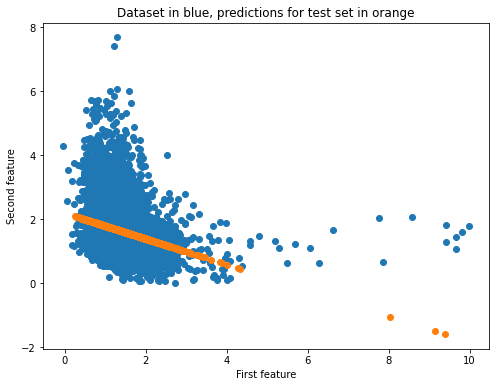

In [345]:
# Plot the test predictions

fig = plt.figure(figsize=(8,6))
plt.title("Dataset in blue, predictions for test set in orange")
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_p_test)
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()